In [1]:
import pandas as pd
import numpy as np
import os
import codecs
import re
path = '/Users/shyam/Desktop/Text Mining/Articles/'

### Reading articles, seperating metadata and creating a corpus

In [2]:
# Set the path to the directory containing the text files
dir_path = '/Users/shyam/Desktop/TextMining/Articles/'
# initialize corpus and metadata strings
corpus = ''
metadata = ''
# loop over all files in the directory
for filename in os.listdir(dir_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(dir_path, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            # split the text into individual articles
            #articles = text.split('\n\n\n')
            articles = re.split('Document.*', text) # seperating articles in documents whenever we find word documents followed by a string indicating document number
            for article in articles:
                # find the start and end of metadata
                index_start = article.find('By ')
                index_end = article.find('Reserved.')
                # extract metadata and add to metadata string
                if index_start != -1 and index_end != -1:
                    metadata += article[index_start:index_end+9] + '\n'
                # remove metadata and add to corpus string
                corpus += article[index_end+10:] + '\n\n\n'

In [3]:
print(len(corpus)) # prints length of corpus

11235293


### Preprocessing

In [4]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import string

# Tokenize and preprocess text
def preprocess(text):
    # Tokenize words and sentences
    tokens = [word.lower() for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    text = re.sub(r'<.*?>', '', text) # remove HTML tags
    text = re.sub(r'\n', ' ', text) # remove newlines
    text = re.sub(r'\d+', '', text) # remove digits
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    text = re.sub(r'\s+', ' ', text) # remove extra spaces
    # Remove stopwords and non-alphabetic characters
    stop = set(stopwords.words('english'))
    # Manipulating stopwords list in accordance with our data
    stop.add('would')
    stop.add('said')
    stop.add('new')
    stop.add('one')
    tokens = [token for token in tokens if token.isalpha() and token not in stop]
    print(f"The Number of tokens in corpus are {len(tokens)}")
    return tokens


In [48]:
# Extract features from text
def extract_features(tokens):
    # Count word frequencies
    word_freq = Counter(tokens)
    # Compute most common words and their frequencies
    most_common = word_freq.most_common(80)
    # Compute average sentence length
    sent_lens = [len(sent_tokenize(sent)) for sent in nltk.sent_tokenize(text)]
    avg_sent_len = sum(sent_lens) / len(sent_lens)
    # Compute number of sentences
    num_sents = len(sent_tokenize(text))
    # Return feature dictionary
    features = {'most_common': most_common, 'avg_sent_len': avg_sent_len, 'num_sents': num_sents}
    return features

In [49]:
# Create summary of features
def summarize_features(features):
    print('Most common words:')
    for word, freq in features['most_common']:
        print(f'{word}: {freq}')
    print(f'Average sentence length: {features["avg_sent_len"]:.2f}')
    print(f'Number of sentences: {features["num_sents"]}')


In [50]:
# Create plots of features
from wordcloud import WordCloud

def plot_features(features):
    words = [word for word, _ in features['most_common']]
    freqs = [freq for _, freq in features['most_common']]
    word_freq_dict = dict(zip(words, freqs))
    wordcloud = WordCloud(background_color='white', width=800, height=400)
    wordcloud.generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

The Number of tokens in corpus are 970772
Most common words:
trump: 7451
state: 7193
islamic: 6203
president: 4197
people: 4039
syria: 3915
american: 3482
united: 3428
military: 3299
states: 3164
also: 3138
iraq: 3072
forces: 2755
government: 2611
like: 2535
isis: 2525
officials: 2457
group: 2426
could: 2360
last: 2250
city: 2218
two: 2174
attack: 2173
syrian: 2149
country: 2136
security: 2080
many: 2060
times: 2056
think: 1943
administration: 1938
time: 1928
years: 1922
first: 1885
iraqi: 1866
york: 1827
even: 1754
going: 1749
e: 1732
russia: 1731
news: 1717
war: 1686
killed: 1678
house: 1638
world: 1610
obama: 1599
week: 1593
may: 1578
say: 1564
back: 1555
year: 1539
mosul: 1517
fighters: 1515
iran: 1510
get: 1502
attacks: 1449
police: 1421
white: 1395
since: 1339
still: 1333
way: 1333
us: 1332
told: 1301
day: 1296
know: 1279
according: 1271
including: 1265
much: 1248
right: 1219
washington: 1216
national: 1209
militants: 1196
afghanistan: 1193
political: 1185
fight: 1184
another: 11

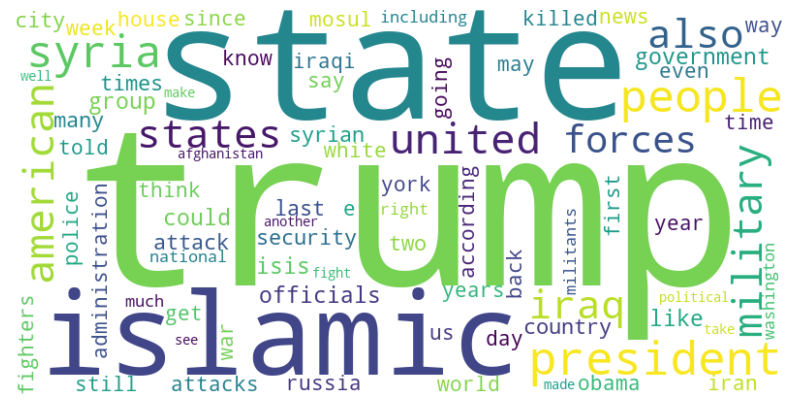

In [51]:
tokens = preprocess(corpus) # runs preprocess function
features = extract_features(tokens) # runs extraxt features function
summarize_features(features) # runs summarize features function
plot_features(features) # runs plot features function

In [56]:
print(tokens[:100])

['washington', 'president', 'trump', 'shifting', 'authority', 'military', 'operations', 'pentagon', 'according', 'white', 'house', 'officials', 'reversing', 'aides', 'generals', 'say', 'tendency', 'obama', 'white', 'house', 'micromanage', 'issues', 'better', 'left', 'military', 'commanders', 'change', 'heart', 'national', 'security', 'council', 'role', 'leader', 'mcmaster', 'reflects', 'trump', 'belief', 'focus', 'less', 'military', 'operations', 'tactics', 'strategic', 'issues', 'guiding', 'precept', 'president', 'team', 'balance', 'power', 'world', 'shifted', 'american', 'interests', 'general', 'mcmaster', 'focus', 'developing', 'foreign', 'economic', 'policy', 'options', 'concert', 'pentagon', 'state', 'department', 'agencies', 'respond', 'challenge', 'approach', 'managing', 'military', 'operations', 'evident', 'month', 'marine', 'artillery', 'battery', 'team', 'army', 'rangers', 'troops', 'arrived', 'northern', 'syria', 'defense', 'secretary', 'jim', 'mattis', 'signed', 'deployment

## Topic Modelling

In [57]:
import re
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load stopwords and lemmatizer
stop_words = stopwords.words('english')
stop_words.append('mr')
stop_words.append('said')
stop_words.append('u')
stop_words.append('also')
stop_words.append('one')
stop_words.append('year')
stop_words.append('new')
stop_words.append('would')
lemmatizer = WordNetLemmatizer()



# Preprocess corpus
corpus = re.sub('\n{3,}', '\n\n', corpus)  # remove excess newlines
corpus = re.sub('[^a-zA-Z\n]+', ' ', corpus)  # remove non-alphabetic characters
corpus = corpus.lower()  # lowercase all text
texts = [[lemmatizer.lemmatize(word) for word in document.split() if word not in stop_words] for document in corpus.split('\n\n\n')]

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Create multiple LDA models with different parameters
for num_topics in [5,10,15]:
    for alpha in [0.1,0.3]:
        for eta in [0.01,0.03]:
            lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha, eta=eta, iterations=100)

            # Calculate coherence score and perplexity
            coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            perplexity = lda_model.log_perplexity(corpus)
            lda_model.save(f'output_files/lda_{num_topics}.model')
            # Store summary in output file
            with open(f'output_files/output_{num_topics}_{alpha}_{eta}.txt', 'w') as f:
                f.write(f'Num Topics: {num_topics}\n')
                f.write(f'Alpha: {alpha}\n')
                f.write(f'Eta: {eta}\n')
                f.write(f'Coherence Score: {coherence_score}\n')
                f.write(f'Perplexity: {perplexity}\n')
                f.write('\n')
                f.write(f'Topics for LDA model with num_topics={num_topics}:\n\n')
                for topic_id, topic in lda_model.show_topics(num_topics=num_topics, formatted=False):
                    f.write(f'Topic {topic_id}:\n')
                    f.write(f'Word    Weight \n')
                    for word, weight in topic:
                        f.write(f'{word}:{weight:.3f}\n')
                    f.write('\n')

            # Visualize topics
            topics = lda_model.show_topics(formatted=False, num_words=10)
            for i, topic in enumerate(topics):
                words = [word[0] for word in topic[1]]
                weights = [word[1] for word in topic[1]]
                print(f'Topic {i+1}: {", ".join(words)}')
                print(f'Weights: {", ".join([str(weight) for weight in weights])}\n')


Topic 1: state, trump, president, islamic, syria, attack, people, iraq, american, isi
Weights: 0.009595179, 0.0062024826, 0.00540637, 0.0052916817, 0.004773099, 0.004714872, 0.004599162, 0.0044885534, 0.003929896, 0.003864886

Topic 2: state, trump, islamic, people, time, american, president, attack, military, official
Weights: 0.00801272, 0.007091743, 0.0052596414, 0.0049599637, 0.004586809, 0.004502214, 0.004329628, 0.004092438, 0.0038517066, 0.0038368294

Topic 3: state, trump, islamic, american, time, force, syria, attack, people, president
Weights: 0.0111515, 0.007629762, 0.0073644705, 0.005591276, 0.00450667, 0.004234051, 0.00411387, 0.003943324, 0.0038461557, 0.0037839916

Topic 4: state, trump, islamic, force, people, time, group, american, president, country
Weights: 0.009034898, 0.008306639, 0.005643357, 0.004574524, 0.0042806207, 0.0041016527, 0.0038455587, 0.0037025746, 0.0036831729, 0.0036174678

Topic 5: state, trump, islamic, president, american, time, country, official,

Topic 1: state, trump, president, american, syria, time, islamic, military, people, force
Weights: 0.010574601, 0.0094667785, 0.0053012087, 0.0047315927, 0.0044367374, 0.0042293975, 0.0041416204, 0.003933211, 0.0038209688, 0.0037517443

Topic 2: islamic, state, trump, american, united, force, syria, attack, people, time
Weights: 0.00927872, 0.008925099, 0.005348364, 0.004751774, 0.004438969, 0.0041834046, 0.004167053, 0.004070008, 0.004047267, 0.0034473897

Topic 3: state, trump, islamic, syria, attack, people, american, force, time, group
Weights: 0.00898124, 0.008257215, 0.0054335496, 0.0050675767, 0.0046843057, 0.0046607526, 0.0044906274, 0.00435562, 0.004005694, 0.0037837669

Topic 4: state, trump, islamic, president, time, military, american, syria, united, group
Weights: 0.010630488, 0.008162103, 0.0060721813, 0.004223974, 0.004078325, 0.004023049, 0.0039967415, 0.0037305295, 0.0036877315, 0.00368028

Topic 5: state, islamic, trump, president, time, syria, american, official, peo

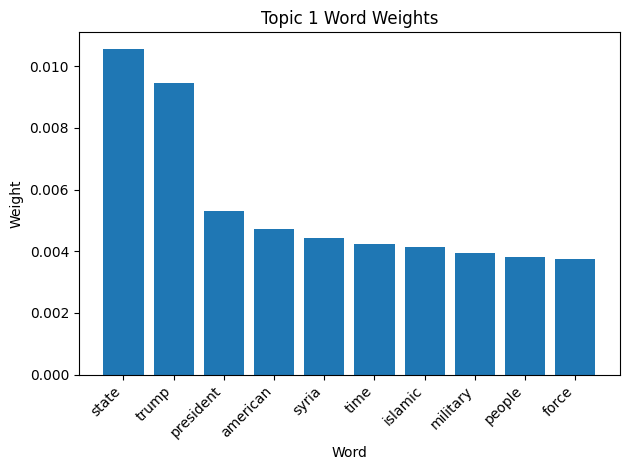

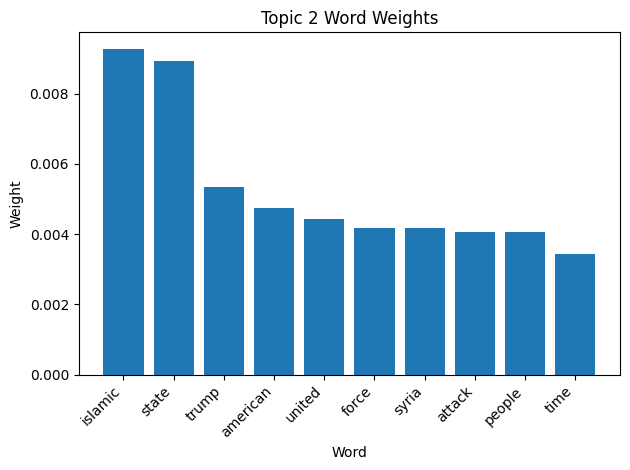

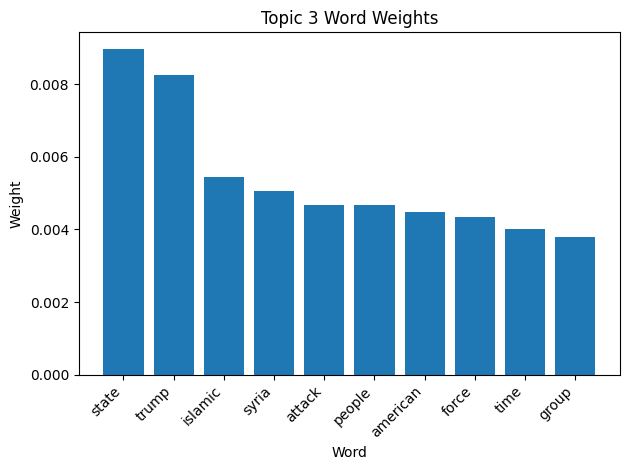

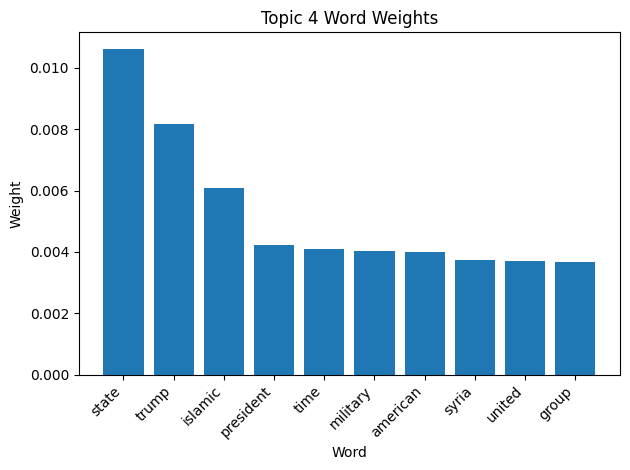

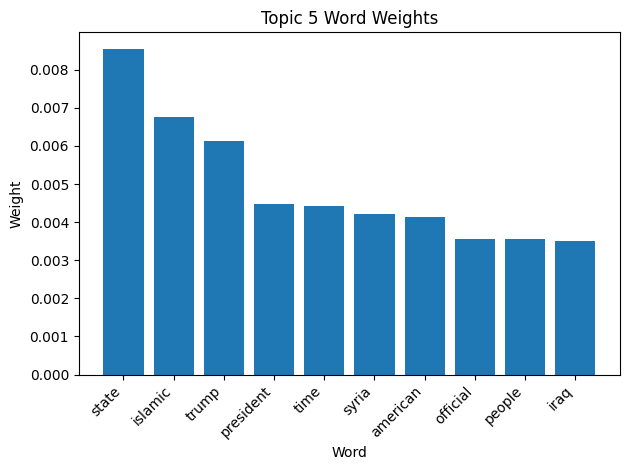

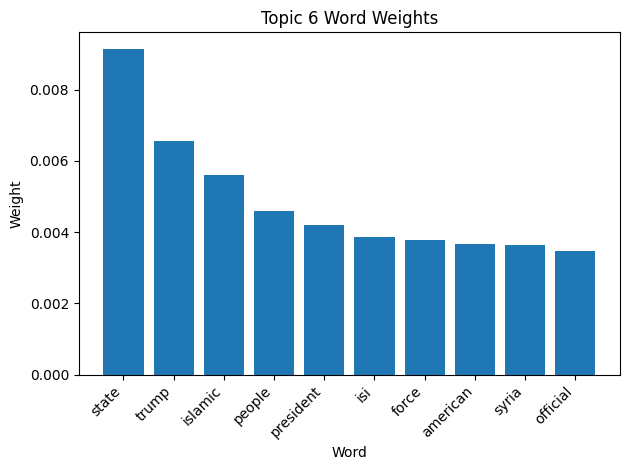

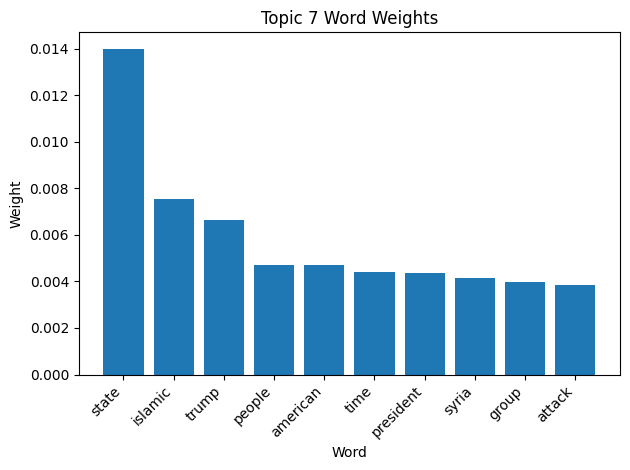

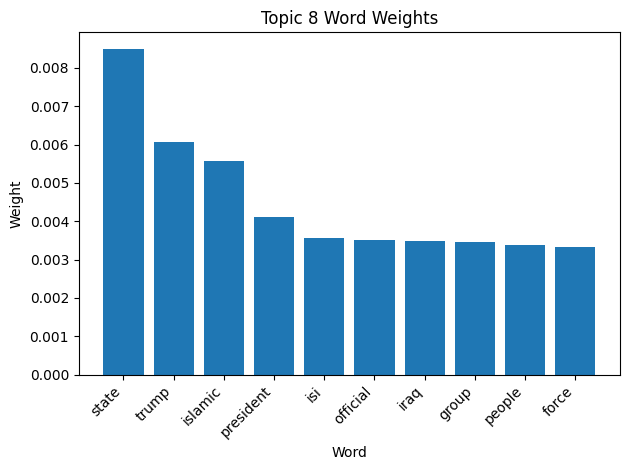

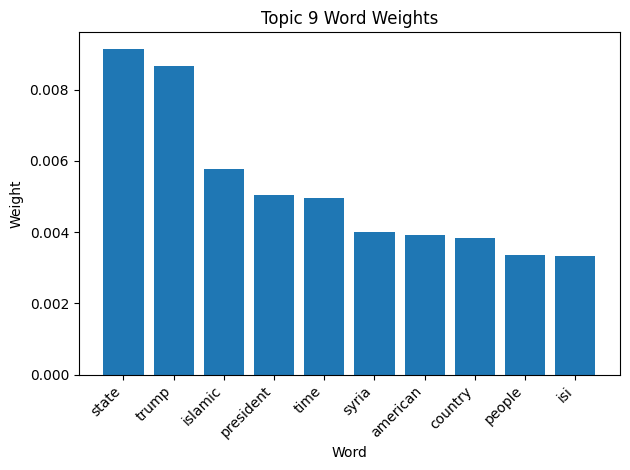

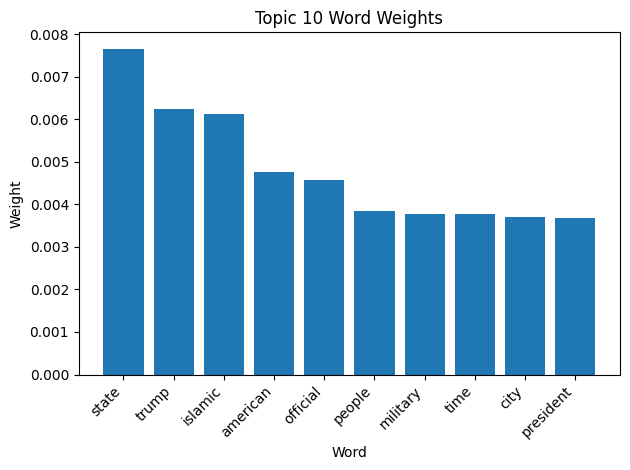

In [59]:
import matplotlib.pyplot as plt

# Visualize topics
topics = lda_model.show_topics(formatted=False, num_words=10)
for i, topic in enumerate(topics):
    words = [word[0] for word in topic[1]]
    weights = [word[1] for word in topic[1]]
    print(f'Topic {i+1}: {", ".join(words)}')
    print(f'Weights: {", ".join([str(weight) for weight in weights])}\n')

    # Plot topic weights
    fig, ax = plt.subplots()
    ax.bar(words, weights)
    ax.set_title(f'Topic {i+1} Word Weights')
    ax.set_xlabel('Word')
    ax.set_ylabel('Weight')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save figure as PNG file
    fig.savefig(f'output_files/topic_{i+1}.png')


In [29]:
topics = lda_model.show_topics(formatted=False, num_words=10)
topics

[(6,
  [('state', 0.009447882),
   ('trump', 0.0069357636),
   ('time', 0.005326902),
   ('islamic', 0.005151323),
   ('president', 0.004584211),
   ('american', 0.004260221),
   ('attack', 0.0041427296),
   ('syria', 0.0039583757),
   ('people', 0.003848228),
   ('group', 0.0038399007)]),
 (14,
  [('state', 0.008707733),
   ('trump', 0.0059016724),
   ('president', 0.0049689473),
   ('islamic', 0.004712792),
   ('force', 0.0039736177),
   ('official', 0.0038291248),
   ('country', 0.0034041344),
   ('united', 0.003381128),
   ('people', 0.003171978),
   ('group', 0.003136955)]),
 (10,
  [('state', 0.009853538),
   ('trump', 0.008228395),
   ('islamic', 0.005873243),
   ('president', 0.0050289524),
   ('time', 0.004383173),
   ('syria', 0.004254171),
   ('force', 0.00412951),
   ('military', 0.003923861),
   ('attack', 0.0038225162),
   ('group', 0.0037503727)]),
 (0,
  [('trump', 0.009056189),
   ('state', 0.008390057),
   ('islamic', 0.004919254),
   ('people', 0.0045430493),
   ('am

In [60]:
topics = lda_model.show_topics(formatted=False, num_words=10)
for i, topic in enumerate(topics):
    words = {word[0]: word[1] for word in topic[1]}
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(words)

    # Plot word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Topic {i+1} Word Cloud')
    plt.tight_layout()

    # Save figure as PNG file
    plt.savefig(f'output_files/topic_wc{i+1}.png')
    plt.close()